In [1]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, random
from jax.scipy.special import gammaln
import matplotlib.pyplot as plt

# Funciona hasta que al final se rompe

La distribución de Poisson es una distribución discreta sobre conteos positivos. Se puede aplicar a sistemas con un gran número de posibles eventos, cada uno de los cuales es poco frecuente. Tiene como función de probabilidad:

para x = 0,1,2,...
$$
p(x;\lambda) = e^{-\lambda} \frac{\lambda^x}{x!}
$$

donde 𝑥 es el valor y 𝜆 > 0 el parámetro de la Poisson. Consideramos un experimento aleatorio en el que medimos una determinada variable aleatoria 𝑋, que sigue una distribución de Poisson (𝑋 ∼ 𝑃𝑜𝑖𝑠(𝜆)). Tomamos 𝑛 medidas independientes de 𝑋 y obtenemos una muestra aleatoria simple {𝑥1, ... , 𝑥𝑛}, donde cada 𝑥𝑖 es una realización de 𝑋, para 𝑖 = 1, ... , 𝑛.

## Apartado a

Vamos a construir la función de log verosimilitud (negativa) de la muestra.

El primer paso será buscar la distribución conjunta de las variables aleatorias tal que:
$$
L(X;σ) = f(X_{1},σ) ⋅ f(X_{2},σ) ⋅ ... ⋅ f(X_{n},σ) = Π_{i=1}^{n} f(X_{i},σ)
$$

Para la distribución de Poisson está disitribución conjunta se representa de la siguiente manera:
$$
L(X;λ) = \frac{e^{-nλ} ⋅ λ^{Σ_{i=1}^{n}x_{i}}}{Π_{i=1}^{n}x_{i}!}
$$

A esta distribución $L(x,λ)$ le aplicaremos el negativo del logaritmo natural para obtener la función de log verosmilitud de la muestra.
$$
-ln[L(x;λ] = -ln(e^{-nλ}) - ln(λ^{Σ_{i=1}^{n}x_{i}}) + ln(Π_{i=1}^{n}x_{i}!) = 
$$

$$
= nλ - Σ_{i=1}^{n}x_{i}⋅lnλ + Σ_{i=1}^{n}ln(x_{i}!)
$$

## Apartado b

Vamos a encontrar el estimador de máxima verosimilitud para 𝜆 a partir de la muestra.

Lo primero será derivar respecto al parámetro poblacional $λ$ la función de log verosimilitud encontrada en el apartado anterior.
$$
\frac{d}{dλ}-ln[L(x;λ)] = n - Σ_{i=1}^{n}x_{i} ⋅ \frac{1}{λ}
$$

El siguiente paso será igualar la derivada obtenida a 0 para poder encontrar el estimador de máxima verosimilitud para $λ$ y obtenemos lo siguiente.
$$
\hat{λ} = \frac{Σ_{i=1}^{n}x_{i}}{n}
$$

Podemos ver como el estimador que hemos obtenido es igual a la representación del promedio de los valores aleatorios $x_{i}$ ($\hat{X}$).

## Apartado c

En este apartado demostramos que realmente es un mínimo (y no un extremo cualquiera).

Para comprobar que el estimador obtenido en el apartado anterior $\hat{λ}$ se trata de un mínimo, tomaremos segundas derivadas y estudiaremos el resultado obtenido.
$$
\frac{d}{dλ}[\frac{d}{dλ}-ln[L(x,λ)]] = \frac{Σ_{i=1}^{n}x_{i}}{λ^{2}}
$$

Viendo este resultado podemos ver que el resultado siempre será un valor positivo debido a que el rango de nuestras x es 0,1..n y el valor de $λ$ al estar elevado a 2, también tendrá por valor siempre un número positivo. Sabiendo esto, podemos concluir y confirmar que el estimador obtenido en el apartado b, se trata realmente de un mínimo.

## Apartado d

En este apartado estimaremos la log verosimilitud de la función Poisson para un única muestra utilizando JAX. Con dicha función, podremos aplicar descenso de gradiente.

In [2]:
@jax.jit
def log_verosimiltude_function(p,x):
    return jnp.subtract(jnp.sum(jnp.array([p, gammaln(x+1)])), jnp.multiply(x, (jnp.log(p))))

@jax.jit
def lossMAE(p, x, y):
  return jnp.abs(log_verosimiltude_function(p,x) - y)

@jax.jit
def lossMSE(p, x, y):
  return (log_verosimiltude_function(p,x) - y)**2

Lo primero que haremos será generar muestras independientes de tamaños 100, 1000, 5000 para una distribución Poisson con un 𝜆 de valor igual a 3.

In [4]:
# Para tener muestras independientes se divide la llave en 3 y cada generación se hace con una parte del split de la llave distinta
lbd = 3
key = jax.random.PRNGKey(0)
randomKeys = jax.random.split(key, 3)
sample100 = jax.random.poisson(randomKeys[0], lbd, shape=(100,))
sample1000 = jax.random.poisson(randomKeys[1], lbd, shape=(1000,))
sample5000 = jax.random.poisson(randomKeys[2], lbd, shape=(5000,))

Haciendo uso de histogramas vemos la distribución de cada una de las muestras.

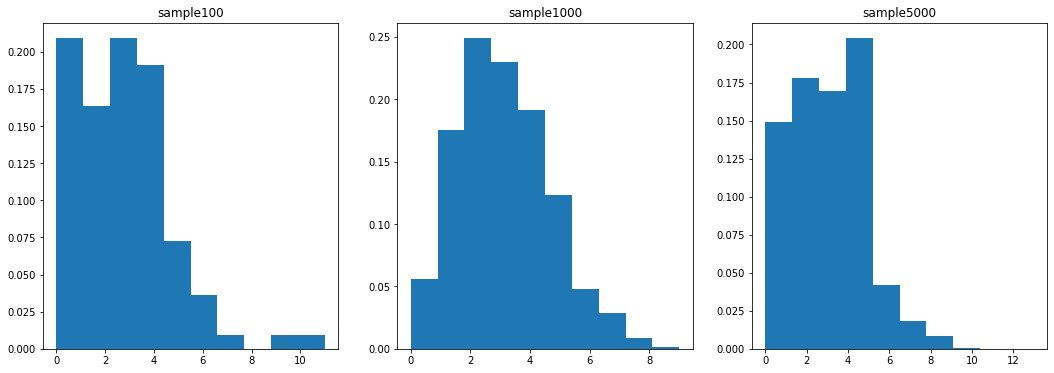

In [5]:
fig, ax = plt.subplots(1,3,figsize=(18,6));

sample100_xlim = jnp.max(sample100)
sample100_x = jnp.linspace(0, sample100_xlim, num = sample100_xlim + 1).astype(float)
sample100_y = vmap(log_verosimiltude_function, in_axes=(None,0))(lbd, sample100_x)
ax[0].hist(sample100, density=True)

sample1000_xlim = jnp.max(sample1000)
sample1000_x = jnp.linspace(0, sample1000_xlim, num = sample1000_xlim + 1).astype(float)
sample1000_y = vmap(log_verosimiltude_function, in_axes=(None,0))(lbd, sample1000_x)
ax[1].hist(sample1000, density=True)

sample5000_xlim = jnp.max(sample5000)
sample5000_x = jnp.linspace(0, sample5000_xlim, num = sample5000_xlim + 1).astype(float)
sample5000_y = vmap(log_verosimiltude_function, in_axes=(None,0))(lbd, sample5000_x)
ax[2].hist(sample5000, density=True)

# plots interface settings
ax[0].set_title('sample100');
ax[1].set_title('sample1000');
ax[2].set_title('sample5000');

Lo siguiente será implementar un algoritmo de descenso de gradiente utilizando JAX para optimizar la log verosimilitud y estimar el parámetro de la distribución, para cada una de las muestras, explorando la tasa de aprendizaje y el número máximo de iteraciones.

Para cada una de las muestras hemos probado con diferentes learning rates y número de iteraciones hasta encontrar con los idóneos. El learning rate define que tan rápido se adaptará el modelo al problema.

### sample 1

In [6]:
epsilon = 1e-10
lr = 0.01
paramMSE = 2.
grad_MSE = jit(grad(lossMSE))
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample100_x,sample100_y).mean(0)

sample100_paramMSE = [paramMSE]
sample100_plossMSE = [ploss]
for i in range(1000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample100_x,sample100_y)
  paramMSE -= (lr * part.mean(0))
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample100_x,sample100_y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:', i)
    break
  ploss = loss
  sample100_paramMSE.append(paramMSE)
  sample100_plossMSE.append(ploss)

print('Lambda:', paramMSE, ' Loss:', loss)

Number of iterations: 240
Lambda: 2.999975  Loss: 1.2830176e-09


In [7]:
epsilon = 1e-10
lr = 0.001
paramMAE = 2.
ploss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample100_x,sample100_y).mean(0)

sample100_paramMAE = [paramMAE]
sample100_plossMAE = [ploss]
for i in range(10000):
  part = vmap(grad(lossMAE),in_axes=(None,0,0))(paramMAE,sample100_x,sample100_y)
  paramMAE -= (lr * part.mean(0))
  loss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample100_x,sample100_y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:', i)
    break
  ploss = loss
  sample100_paramMAE.append(paramMAE)
  sample100_plossMAE.append(ploss)

print('Lambda:', paramMSE, ' Loss:', loss)

Lambda: 2.999975  Loss: 1.1424224e-05


Podemos ver como haciendo uso del error cuadrático medio (MSE) obtenemos resultados algo mejor que con el error absoluto medio (MAE). Probablemente debido a que el MAE pesa menos errores más grandes. Aún así, ambos resultados son relativamente buenos.

Los respectivos valores para el learning rate y el número de iteraciones son los que mejor resultados nos han dado.

### sample2

In [8]:
epsilon = 1e-10
lr = 0.1
paramMSE = 2.
grad_MSE = jit(grad(lossMSE))
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample1000_x,sample1000_y).mean(0)

sample1000_paramMSE = [paramMSE]
sample1000_plossMSE = [ploss]
for i in range(1000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample1000_x,sample1000_y)
  paramMSE -= (lr * part.mean(0))
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample1000_x,sample1000_y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:', i)
    break
  ploss = loss
  sample1000_paramMSE.append(paramMSE)
  sample1000_plossMSE.append(ploss)

print('Lambda:', paramMSE, ' Loss:', loss)

Number of iterations: 39
Lambda: 2.9999907  Loss: 1.0050485e-10


In [9]:
epsilon = 1e-10
lr = 0.001
paramMAE = 2.
ploss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample1000_x,sample1000_y).mean(0)

sample1000_paramMAE = [paramMAE]
sample1000_plossMAE = [ploss]
for i in range(1000):
  part = vmap(grad(lossMAE),in_axes=(None,0,0))(paramMAE,sample1000_x,sample1000_y)
  paramMAE -= (lr * part.mean(0))
  loss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample1000_x,sample1000_y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:', i)
    break
  ploss = loss
  sample1000_paramMAE.append(paramMAE)
  sample1000_plossMAE.append(ploss)

print('Lambda:', paramMSE, ' Loss:', loss)

Lambda: 2.9999907  Loss: 0.00071535114


Una vez más, podemos ver como haciendo uso del error cuadrático medio (MSE) obtenemos resultados algo mejor que con el error absoluto medio (MAE). Probablemente debido a que el MAE pesa menos errores más grandes. Aún así, ambos resultados son relativamente buenos.

Los respectivos valores para el learning rate y el número de iteraciones son los que mejor resultados nos han dado.

### sample3

In [10]:
epsilon = 1e-10
lr = 0.01
paramMSE = 2.
grad_MSE = jit(grad(lossMSE))
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample5000_x,sample5000_y).mean(0)

sample5000_paramMSE = [paramMSE]
sample5000_plossMSE = [ploss]
for i in range(1000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample5000_x,sample5000_y)
  paramMSE -= (lr * part.mean(0))
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample5000_x,sample5000_y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:', i)
    break
  ploss = loss
  sample5000_paramMSE.append(paramMSE)
  sample5000_plossMSE.append(ploss)

print('Lambda:', paramMSE, ' Loss:', loss)

Number of iterations: 158
Lambda: 2.9999843  Loss: 7.992672e-10


In [11]:
epsilon = 1e-10
lr = 0.0001
paramMAE = 2.
ploss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample5000_x,sample5000_y).mean(0)

sample5000_paramMAE = [paramMAE]
sample5000_plossMAE = [ploss]
for i in range(10000):
  part = vmap(grad(lossMAE),in_axes=(None,0,0))(paramMAE,sample5000_x,sample5000_y)
  paramMAE -= (lr * part.mean(0))
  loss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample5000_x,sample5000_y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations: ', i)
    break
  ploss = loss
  sample5000_paramMAE.append(paramMAE)
  sample5000_plossMAE.append(ploss)

print('Lambda:', paramMSE, ' Loss:', loss)

Lambda: 2.9999843  Loss: 0.00014633793


Una vez más, podemos ver como haciendo uso del error cuadrático medio (MSE) obtenemos resultados algo mejor que con el error absoluto medio (MAE). Probablemente debido a que el MAE pesa menos errores más grandes. Aún así, ambos resultados son relativamente buenos.

Los respectivos valores para el learning rate y el número de iteraciones son los que mejor resultados nos han dado.

Ahora vamos a estudiar la evolución de los parámetros y de la función de error para cada muestra y cada uno de los casos.

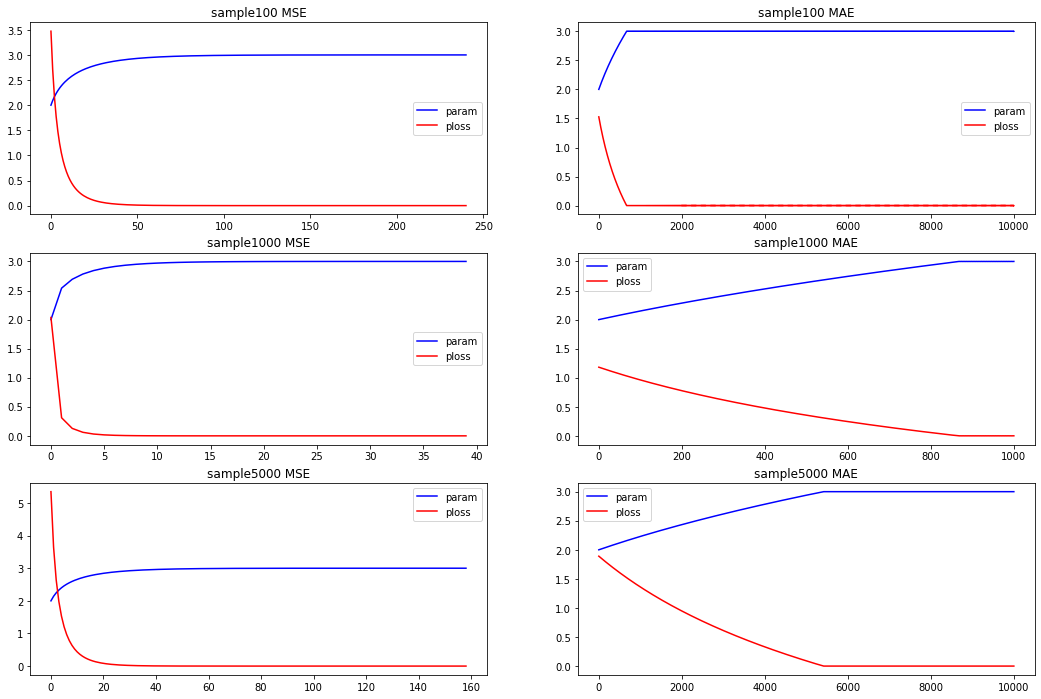

In [12]:
fig, ax = plt.subplots(3,2,figsize=(18,12));

ax[0][0].plot(sample100_paramMSE, color='b', label='param');
ax[0][0].plot(sample100_plossMSE, color='r', label='ploss');
ax[0][1].plot(sample100_paramMAE, color='b', label='param');
ax[0][1].plot(sample100_plossMAE, color='r', label='ploss');

ax[1][0].plot(sample1000_paramMSE, color='b', label='param');
ax[1][0].plot(sample1000_plossMSE, color='r', label='ploss');
ax[1][1].plot(sample1000_paramMAE, color='b', label='param');
ax[1][1].plot(sample1000_plossMAE, color='r', label='ploss');

ax[2][0].plot(sample5000_paramMSE, color='b', label='param');
ax[2][0].plot(sample5000_plossMSE, color='r', label='ploss');
ax[2][1].plot(sample5000_paramMAE, color='b', label='param');
ax[2][1].plot(sample5000_plossMAE, color='r', label='ploss');

# plots interface settings
ax[0][0].set_title('sample100 MSE');
ax[0][0].legend();
ax[0][1].set_title('sample100 MAE');
ax[0][1].legend();
ax[1][0].set_title('sample1000 MSE');
ax[1][0].legend();
ax[1][1].set_title('sample1000 MAE');
ax[1][1].legend();
ax[2][0].set_title('sample5000 MSE');
ax[2][0].legend();
ax[2][1].set_title('sample5000 MAE');
ax[2][1].legend();

Podemos ver que en todos los casos la evolución del error cuádratico en comparación a la del error absoluto, de una misma muestra, tiene una evolución mucho más suave. Esto es debido a que MSE se trata de una función de parábola. Por otro lado, en la función MAE, observamos una evolución lineal marcada por tramos distingibles por puntos de transición.

## Apartado e

La regresión de Poisson asume una relación que es lineal entre los atributos de las muestras y el logaritmo del parámetro 𝜆 de manera que:

$$
𝜆 = exp(𝑤⋅𝑣)
$$

donde ahora 𝑤 son los parámetros de nuestra distribución y 𝑣 es el vector de atributos asociado a los ejemplos. Asumiremos que la relación en nuestro problema es (𝑎 + 𝑏 ⋅ 𝑡), de manera que al aumentar el tiempo (𝑡) la tasa de error va creciendo.

In [13]:
@jax.jit
def error_rate_function(p,t):
  return jnp.sum(p*jnp.array([1,t]));

@jax.jit
def lossMAE(p,x,y):
  return jnp.abs(error_rate_function(p,x) - y)

@jax.jit
def lossMSE(p,x,y):
  return (error_rate_function(p,x) - y)**2

Generamos muestras que sigan la relación (2 + 0,05 ⋅ 𝑡) tomando 50, 250 y 500 muestras a intervalos regulares en el intervalo [0, 40].

In [14]:
sample50 = jnp.linspace(0,40,50)
sample50_result = vmap(error_rate_function, in_axes=(None, 0))(jnp.array([2,0.05]), sample50)

In [15]:
sample250 = jnp.linspace(0,40,250)
sample250_result = vmap(error_rate_function, in_axes=(None, 0),)(jnp.array([2,0.05]), sample250)

In [16]:
sample500 = jnp.linspace(0,40,500)
sample500_result = vmap(error_rate_function, in_axes=(None, 0),)(jnp.array([2,0.05]), sample500)

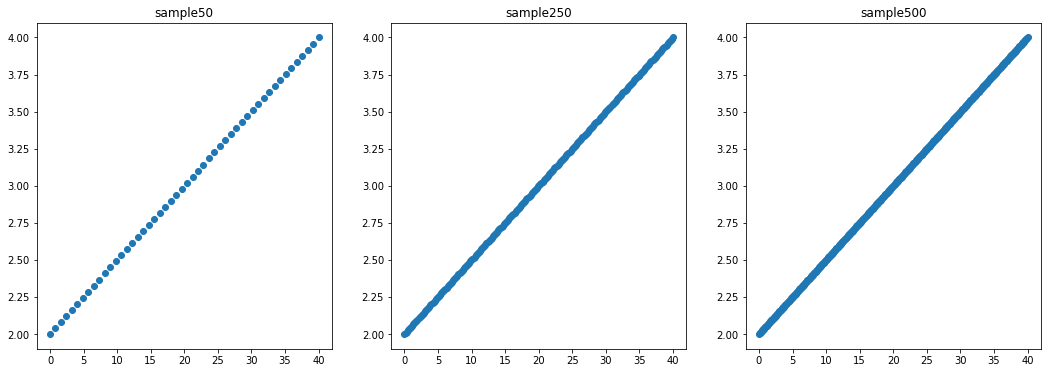

In [17]:
fig, ax = plt.subplots(1,3,figsize=(18,6));

ax[0].scatter(jnp.linspace(0, 40,50),sample50_result);
ax[1].scatter(jnp.linspace(0, 40,250),sample250_result);
ax[2].scatter(jnp.linspace(0, 40,500),sample500_result);

ax[0].set_title('sample50');
ax[1].set_title('sample250');
ax[2].set_title('sample500');

Vamos a estimar los parámetros 𝑎 y 𝑏 usando descenso de gradiente explorando la tasa de aprendizaje y el número máximo de iteraciones.

Como ya hemos visto en otros apartados, el learning rate define el tamaño de cada paso en cada iteración mientras nos movemos hacia un mínimo de una función de pérdidas. En nuestro caso los mejores resultados los hemos obtenidos con learnings rates iguales a 0.001. Con valores muy pequeños, se corre el peligro de necesitar muchas iteraciones. Con valores muy grandes, existe la posibilidad de "ir dando vueltas" debido a que el tamaño del paso entre iteraciones es demasiado elevado.

Vamos a utilizar como valor máximo de iteraciones 10000. Esto es debido que después de hacer pruebas con valores como 1000, por ejemplo, nos daban resultados como [2.5835729  0.02812767], lo cual es peor a los obtenidos actualmente.

Destacar que todas los cálculas que realizaremos a partir de ahora serán con la muestra de 500 generada anteriormente ya que con el resto de muestras los resultados obtenidos eran practicamente idénticos.

In [18]:
epsilon = 1e-10
lr = 0.001
paramMSE=jnp.array([3.,1.])
grad_MSE = jit(grad(lossMSE))
y = sample500_result
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample500,y)
  paramMSE -= (lr * part.mean(0))
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:', i)
    break
  ploss = loss

print('Parameter a:', paramMSE[0], ' Parameter b:', paramMSE[1], ' Loss:', loss)

Parameter a: 2.006428  Parameter b: 0.049759075  Loss: 1.0360873e-05


In [19]:
epsilon = 1e-10
lr = 0.001
paramMAE=jnp.array([3.,1.])
y = sample500_result
ploss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad(lossMAE),in_axes=(None,0,0))(paramMAE,sample500,y)
  paramMAE -= (lr * part.mean(0))
  loss = vmap(lossMAE,in_axes=(None,0,0))(paramMAE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:', i)
    break
  ploss = loss

print('Parameter a:', paramMAE[0], ' Parameter b:', paramMAE[1], ' Loss:', loss)

Parameter a: 2.0009995  Parameter b: 0.050055772  Loss: 0.0021148806


Ahora vamos a representar la evolución de la log verosimilitud y los parámetros.

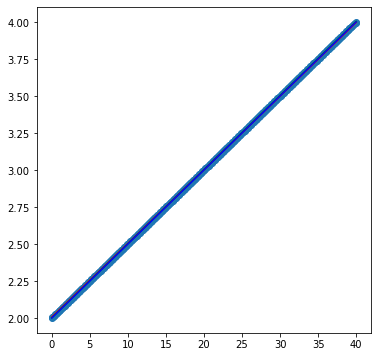

In [20]:
fig = plt.figure(figsize=(6,6))
xlim = jnp.linspace(0,40,500)
dataMSE = vmap(error_rate_function, in_axes=(None,0))(paramMSE, xlim)
dataMAE = vmap(error_rate_function, in_axes=(None,0))(paramMAE, xlim)
real = vmap(error_rate_function, in_axes=(None,0))(jnp.array([2,0.05]), xlim)
plt.plot(xlim,dataMSE, 'r');
plt.plot(xlim,dataMAE, 'g');
plt.plot(xlim,real, 'b');
plt.scatter(jnp.linspace(0,40,500),sample500_result);

Podemos ver como los dos conjuntos de datos, los del MSE y los del MAE, se ajustan de manera idónea a la función original. Esto es debido probablemente al carácter lineal de la función con la que estamos trabajando. Es por esto que, incluso la función del error absoluto que es la que suele desviarse algo más debido a que pesa menos los errores grandes, se ajusta bien también.

## Apartado f

En el apartado anterior hemos podido observar entre otras cosas que el número de iteraciones necesarias para converger es relativamente largo. No siempre podemos asumir que la pendiente de la dirección de descenso del gradiente es igual en todas las dimensiones, a veces cada parámetro necesita su propia tasa de aprendizaje. Es por esto que vamos a modificar que el algoritmo de descenso de gradiente que hemos implementado en el apartado anterior.

### Parámetro a

Vamos a comparar 3 valores distintos para el lerning rate a la hora de optimizar el parámetro a.

In [21]:
epsilon = 1e-10
lr = 0.01
paramMSE=jnp.array([5.,0.05])
grad_MSE = jit(grad(lossMSE))
y = sample500_result
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample500,y)
  paramMSE -= jnp.array([lr * part.mean(0)[0], 0])
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:',i)
    break
  ploss = loss

print('Parameter a:', paramMSE[0], ' Loss:', loss)

Number of iterations: 542
Parameter a: 2.0000515  Loss: 2.6520868e-09


In [22]:
epsilon = 1e-10
lr = 0.001
paramMSE=jnp.array([5.,0.05])
grad_MSE = jit(grad(lossMSE))
y = sample500_result
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample500,y)
  paramMSE -= jnp.array([lr * part.mean(0)[0], 0])
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:',i)
    break
  ploss = loss

print('Parameter a:', paramMSE[0], ' Loss:', loss)

Number of iterations: 4851
Parameter a: 2.0001783  Loss: 3.180412e-08


In [23]:
epsilon = 1e-10
lr = 0.0001
paramMSE=jnp.array([5.,0.05])
grad_MSE = jit(grad(lossMSE))
y = sample500_result
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample500,y)
  paramMSE -= jnp.array([lr * part.mean(0)[0], 0])
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:',i)
    break
  ploss = loss

print('Parameter a:', paramMSE[0], ' Loss:', loss)

Parameter a: 2.4059258  Loss: 0.1647757


Como podemos interpretar con las diferentes salidas, con un learning rate de 0.01 hemos obtenido los mejores resultados y en tan solo 542 iteraciones. Por otro lado, con un learning rate del 0.0001, hemos necesitado las 10000 iteraciones y ni siquiera hemos obtenido unos resultados equiparablemente buenos a los otros dos.

### Parámetro b

Vamos a comparar 3 valores distintos para el lerning rate a la hora de optimizar el parámetro a.

In [24]:
epsilon = 1e-10
lr = 0.01
paramMSE=jnp.array([2.,1.])
grad_MSE = jit(grad(lossMSE))
y = sample500_result
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample500,y)
  paramMSE -= jnp.array([0, lr * part.mean(0)[1]])
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:',i)
    break
  ploss = loss

print('Parameter b:', paramMSE[1], ' Loss:', loss)

Parameter b: nan  Loss: nan


In [25]:
epsilon = 1e-10
lr = 0.001
paramMSE=jnp.array([2.,1.])
grad_MSE = jit(grad(lossMSE))
y = sample500_result
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample500,y)
  paramMSE -= jnp.array([0, lr * part.mean(0)[1]])
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:',i)
    break
  ploss = loss

print('Parameter b:', paramMSE[1], ' Loss:', loss)

Number of iterations: 6
Parameter b: 0.049999993  Loss: 3.8994588e-14


In [26]:
epsilon = 1e-10
lr = 0.0001
paramMSE=jnp.array([2.,1.])
grad_MSE = jit(grad(lossMSE))
y = sample500_result
ploss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
for i in range(10000):
  part = vmap(grad_MSE,in_axes=(None,0,0))(paramMSE,sample500,y)
  paramMSE -= jnp.array([0, lr * part.mean(0)[1]])
  loss = vmap(lossMSE,in_axes=(None,0,0))(paramMSE,sample500,y).mean(0)
  if jnp.abs(ploss - loss) < epsilon:
    print('Number of iterations:',i)
    break
  ploss = loss

print('Parameter b:', paramMSE[1], ' Loss:', loss)

Number of iterations: 123
Parameter b: 0.05000079  Loss: 3.3305958e-10


A la hora de aproximar este parámetro b, obtenemos resultado muy distintos y curiosos. El mejor resultado lo obtenemos con un learning rate del 0.001 al cual llegamos con tan solo 6 iteraciones. Por otro lado en el primer apartado, cuando utilizamos un learning rate del 0.01, obtenemos como resultado del parámetro b el valor nan.

Lo que ocurre en este apartado es que si el gradiente es muy grande necesitaremos un learning rate muy pequeño, sino, al sumarle a los parámetros el coeficiente $grad*lr$ nos queda una distancia más alejada de la original. Esta distancia se va a ir alejando cada vez más y más en cada iteración hasta devolver el valor nan.